In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Load data

In [133]:
data_success = pd.read_csv('clean_data_success.csv')
data_bechdel = pd.read_csv('clean_data_bechdel.csv')
data_character = pd.read_csv('clean_data_character.csv')
data_original = pd.read_csv('clean_data_original.csv')
ethnicity_df = pd.read_csv('ethnicity_labels.csv')


In [134]:
data_success.head()

,Unnamed: 0,Wiki_ID,Movie_ID,title,release_date,BoxOfficeRevenue,Runtime,Languages,Countries,Genres,Year,BoxOfficeStandardize,budget,Net_revenue,rating,BoxOfficeRank,RatingRank,SuccessMetric
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,0.005032,28000000.0,-13989168.0,4.850459,0.299224,0.089868,0.194546
1,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,0.001290,2000000.0,1600000.0,5.800000,0.122851,0.289639,0.206245
2,13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,0.003649,9000000.0,1161099.0,7.450000,0.234886,0.903072,0.568979
3,17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,0.036755,6000000.0,96272727.0,7.600000,0.743206,0.931883,0.837544
4,29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2001,0.010557,16000000.0,13381649.0,6.900000,0.454798,0.732303,0.593550


In [135]:
ethnicity_df['ethnic_cat'] = ethnicity_df.index
data_character = pd.merge(data_character, ethnicity_df[['ethnicity_ID', 'ethnic_cat']], on='ethnicity_ID', how='left')

ethnicity_df.head()

,ethnicity_ID,wikidata_id,ethnicity_label,corresponding_ethnicity,count,ethnic_cat
0,/m/044038p,NaN,Canadian,NaN,145,0
1,/m/0x67,Q49085,African Americans,https://en.wikipedia.org/wiki/African_Americans,1464,1
2,/m/064b9n,Q120601,Omaha Tribe of Nebraska,https://en.wikipedia.org/wiki/Omaha_people,1,2
3,/m/041rx,Q7325,Jewish people,https://en.wikipedia.org/wiki/Jews,703,3
4,/m/033tf_,Q1075293,Irish Americans,https://en.wikipedia.org/wiki/Irish_Americans,196,4


In [136]:
data_success['num_actors'] = data_success['Movie_ID'].map(
                                                    data_character.groupby('Movie_ID')['Actor_ID'].nunique()
                                                    )

data_success['num_women'] = data_success['Movie_ID'].map(
                                                    data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique()
                                                )

data_success['ratio_W/M'] = data_success['num_women']/data_success['num_actors']

In [137]:
women_data = data_character[data_character['actor_gender']=='F'].copy()
men_data = data_character[data_character['actor_gender']=='M'].copy()

In [138]:

valid_mask = (data_success['ratio_W/M'] >= 0) & (data_success['num_actors'] > 4)
data_imdb_women = data_success[valid_mask].copy()

valid_mask = (women_data['actor_age_movie_released'] > 18)
women_data_crop = women_data[valid_mask].copy()


analysis = pd.merge(
                        women_data[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
                        data_imdb_women.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'ratio_W/M', 'rating']],
                        on='Movie_ID',
                        how = 'inner'
                        )

mean_women_data = analysis.groupby('Movie_ID').agg(
                                                    mean_age=('actor_age_movie_released', 'mean'),
                                                    num_women=('actor_age_movie_released', 'size'),
                                                    title=('title', 'first'),
                                                    SuccessMetric=('SuccessMetric', 'first'),
                                                    ratio_W_M = ('ratio_W/M', 'first'),
                                                    avg_ethnic = ('ethnic_cat', 'mean'),
                                                    avg_height = ('actor_height', 'mean'),
                                                    Rating = ('rating', 'first')
                                                ).reset_index()

mean_women_data.shape

(3434, 9)

In [140]:
# Assuming mean_age_data is a NumPy array or structured data
ages = mean_women_data['mean_age']
success_scores = mean_women_data['Rating']

# Filter out NaN values
valid_mask = ~np.isnan(ages) & ~np.isnan(success_scores)

# Compute correlation using valid data only
correlation = np.corrcoef(ages[valid_mask], success_scores[valid_mask])[0, 1]

print(f"Correlation between actress age and movie success score: {correlation}")

Correlation between actress age and movie success score: 0.04881162087303009


In [126]:
mean_women_data.sort_values(by= "SuccessMetric", ascending=False)[:5]

,Movie_ID,mean_age,num_women,title,SuccessMetric,ratio_W_M,avg_ethnic,avg_height,Rating
94,/m/017jd9,27.000000,5,The Lord of the Rings: The Return of the King,0.998491,0.172414,86.0,1.723667,8.549447
2710,/m/0btpm6,34.666667,3,The Dark Knight,0.998275,0.120000,43.0,1.725000,8.649991
93,/m/017gm7,28.000000,5,The Lord of the Rings: The Two Towers,0.996203,0.131579,86.0,1.723667,8.399414
92,/m/017gl1,28.666667,4,The Lord of the Rings: The Fellowship of the Ring,0.995523,0.137931,86.0,1.760000,8.450000
1881,/m/0661ql3,27.000000,3,Inception,0.994964,0.200000,23.0,1.663333,8.449994


In [127]:
data_imdb_women.head()

,Unnamed: 0,Wiki_ID,Movie_ID,title,release_date,BoxOfficeRevenue,Runtime,Languages,Countries,Genres,...,BoxOfficeStandardize,budget,Net_revenue,rating,BoxOfficeRank,RatingRank,SuccessMetric,num_actors,num_women,ratio_W/M
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",...,0.005032,28000000.0,-13989168.0,4.850459,0.299224,0.089868,0.194546,17.0,6.0,0.352941
2,13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",...,0.003649,9000000.0,1161099.0,7.450000,0.234886,0.903072,0.568979,21.0,3.0,0.142857
3,17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",...,0.036755,6000000.0,96272727.0,7.600000,0.743206,0.931883,0.837544,9.0,6.0,0.666667
4,29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",...,0.010557,16000000.0,13381649.0,6.900000,0.454798,0.732303,0.593550,37.0,12.0,0.324324
5,49,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",...,0.012336,5000000.0,29331783.0,7.200000,0.489739,0.831712,0.660725,13.0,1.0,0.076923


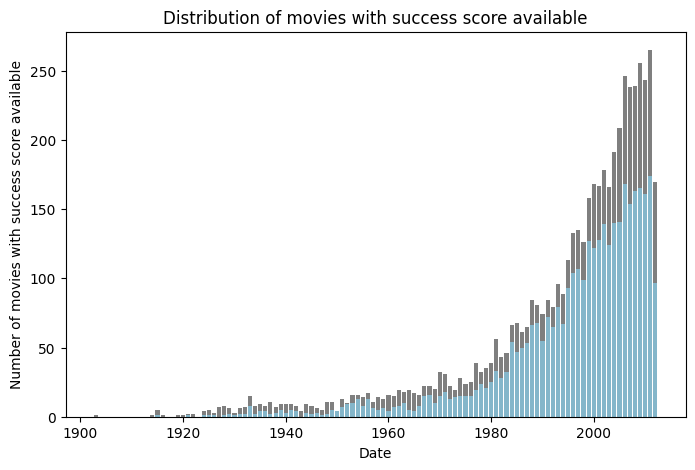

In [145]:
movies_years_scores = data_success.dropna(subset=['SuccessMetric']).groupby('Year').agg(
                                                    count=('Year', 'size')
                                                ).reset_index()

movies_years = data_success.groupby('Year').agg(
                                                    count=('Year', 'size')
                                                ).reset_index()

plt.figure(figsize=(8, 5))
plt.bar(movies_years['Year'], movies_years['count'], color='black', label='Total Movies', alpha=0.5)
plt.bar(movies_years_scores['Year'], movies_years_scores['count'], color='skyblue', label='With Success Score', alpha=0.7)


# Set plot labels and title
plt.title('Distribution of movies with success score available')
plt.xlabel('Date')
plt.ylabel('Number of movies with success score available')
plt.xticks(rotation=0)
plt.show()

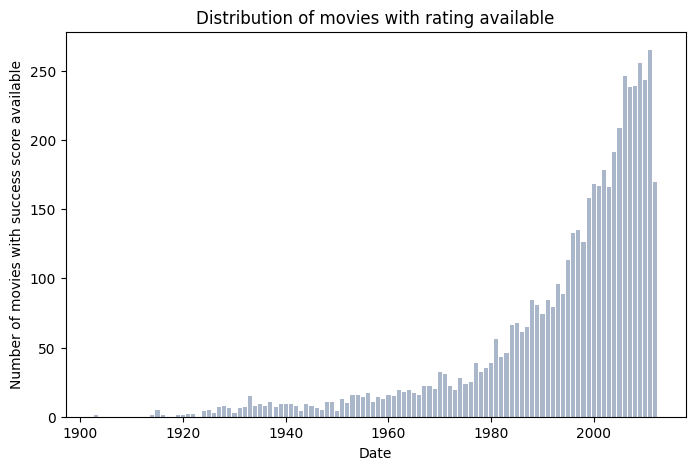

In [146]:
movies_years_ratings = data_success.dropna(subset=['rating']).groupby('Year').agg(
                                                    count=('Year', 'size')
                                                ).reset_index()


plt.figure(figsize=(8, 5))
plt.bar(movies_years_ratings['Year'], movies_years_ratings['count'], color='red', label='Total Movies', alpha=0.5)

plt.bar(movies_years['Year'], movies_years['count'], color='skyblue', label='With Success Score', alpha=0.7)


# Set plot labels and title
plt.title('Distribution of movies with rating available')
plt.xlabel('Date')
plt.ylabel('Number of movies with success score available')
plt.xticks(rotation=0)
plt.show()

In [131]:
data_imdb.describe()

,Unnamed: 0,Wiki_ID,BoxOfficeRevenue,Runtime,Year,BoxOfficeStandardize,budget,Net_revenue,rating,BoxOfficeRank,RatingRank,SuccessMetric,num_actors,num_women,ratio_W/M
count,5241.000000,5.241000e+03,3.606000e+03,5157.000000,5241.00000,3.586000e+03,5.241000e+03,3.606000e+03,5241.000000,3606.000000,5241.000000,3606.000000,5169.000000,4936.000000,4936.000000
mean,41089.008586,8.129403e+06,8.945980e+07,107.396228,1994.33734,3.213316e-02,2.502241e+07,5.714028e+07,6.235033,0.500139,0.500095,0.514195,13.300251,4.186386,0.315891
std,23585.293053,1.006904e+07,1.502989e+08,27.767389,18.03603,5.401618e-02,3.423608e+07,1.283281e+08,1.020494,0.288715,0.288686,0.215034,6.451834,2.771564,0.155503
min,0.000000,3.217000e+03,1.047400e+04,4.000000,1903.00000,1.703648e-07,1.000000e+00,-1.191800e+08,0.950000,0.000277,0.000191,0.005139,1.000000,1.000000,0.032258
25%,20751.000000,8.938080e+05,1.100000e+07,93.000000,1988.00000,3.950096e-03,3.000000e+06,-1.408730e+06,5.650000,0.250139,0.247186,0.354642,10.000000,2.000000,0.200000
50%,40865.000000,3.038038e+06,3.547981e+07,103.000000,2000.00000,1.281639e-02,1.250000e+07,1.458066e+07,6.350000,0.500139,0.507918,0.517964,13.000000,4.000000,0.300000
75%,61932.000000,1.269050e+07,1.048954e+08,118.000000,2007.00000,3.769786e-02,3.200000e+07,6.686789e+07,6.950000,0.750069,0.751670,0.674678,16.000000,6.000000,0.400000
max,81720.000000,3.681425e+07,2.782275e+09,1003.000000,2012.00000,1.000000e+00,3.800000e+08,2.545275e+09,8.900000,1.000000,1.000000,0.998491,115.000000,29.000000,1.000000


In [147]:
analysis.shape

(15866, 9)

In [148]:
analysis.head()

,actor_age_movie_released,Movie_ID,actor_name,ethnic_cat,actor_height,title,SuccessMetric,ratio_W/M,rating
0,42.0,/m/03vyhn,Wanda De Jesus,NaN,1.620,Ghosts of Mars,0.194546,0.352941,4.850459
1,27.0,/m/03vyhn,Natasha Henstridge,0.0,1.780,Ghosts of Mars,0.194546,0.352941,4.850459
2,23.0,/m/03vyhn,Clea DuVall,NaN,1.650,Ghosts of Mars,0.194546,0.352941,4.850459
3,52.0,/m/03vyhn,Pam Grier,1.0,1.727,Ghosts of Mars,0.194546,0.352941,4.850459
4,56.0,/m/03vyhn,Joanna Cassidy,NaN,1.753,Ghosts of Mars,0.194546,0.352941,4.850459


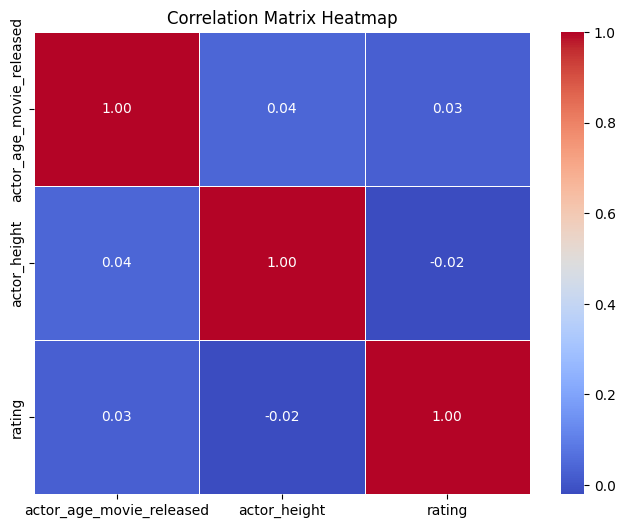

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = analysis[['actor_age_movie_released', 'actor_height', 'rating']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


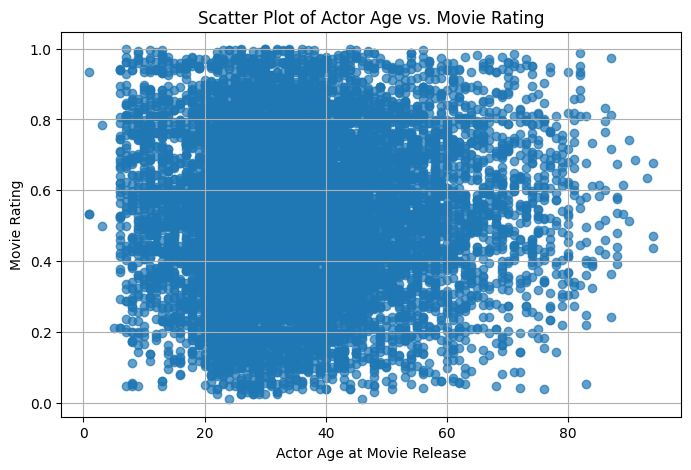

In [154]:
import matplotlib.pyplot as plt

# Example data
x = analysis['actor_age_movie_released']
y = analysis['SuccessMetric']

# Basic scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Actor Age at Movie Release")
plt.ylabel("Movie Rating")
plt.title("Scatter Plot of Actor Age vs. Movie Success Score")
plt.grid(True)
plt.show()


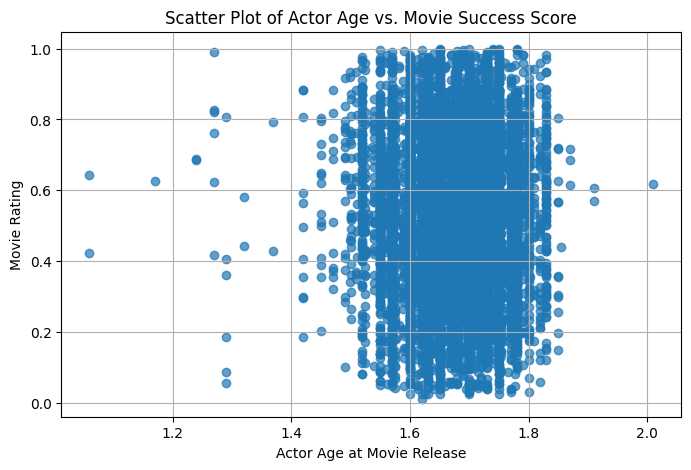

In [156]:
import matplotlib.pyplot as plt

# Example data
x = analysis['actor_height']
y = analysis['SuccessMetric']

# Basic scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Actor Age at Movie Release")
plt.ylabel("Movie Rating")
plt.title("Scatter Plot of Actor Age vs. Movie Success Score")
plt.grid(True)
plt.show()
